## Fina Short UEP239 Final Project: Introduction

In this project I will execute a suitability analysis determining the most suitable ZIP Code Tabulation Area (ZCTA) for recent college grads like me to inhabit. The project focuses on the Boston Metropolitan Area as defined by the boundary of the Boston Region Metropolitan Planning Organization (MPO). The analysis uses the following  indicators to calculate and map suitability for this demographic:

**Points of Interest: transit access** 
- Areas with more 1) MBTA bus stops and 2) MBTA T stations will help us get around in a cost-effective way.

**Feeding ourselves: fresh food access**
- Prevalence of farmer's markets: my environmentally-conscious generation loves eating local when we can.

**Demographics of Interest: Age, Housing Price and Pop. Density**
- Mean housing price/rent payment, where lowest rent means most suitable
- Age distribution of neighborhood population, with ages in the 20-24 range ranked highest
- Population density, where densest = best (the more the merrier!)

## Analysis overview

Below is a rough outline of the analysis I will perform:
1. **Pinpoint area of focus** > join MA Read in, visualize, and join Massachusetts base map data to pinpoint our field of analysis
2. **Measure train access** > join MBTA nodes file to Boston Zip Codes data > normalize to index on 0-1 scale where 1= high suitability with most T stations per zip code
3. **Measure bus access** > join MBTA bus stops file to Boston Zip Codes data > normalize to index on 0-1 scale where 1= high suitability with most bus stops per zip code
4. **Assess median housing price** > join census data to Boston Zip Codes data to calculate housing by zip > normalize to index on 0-1 scale where 1= high suitability with lowest rent
5. **Calculate population age distribution** > use ACS population data to determine age averages by region > reclassify > (closest to = high risk) (25 pts)
6. Calculate weighted and unweighted suitability map from all indexed indicators

How will we quantify a suitable "zip code tabulation area?" Using the following data:
- **U.S. Census Bureau, 2015-2019 American Community Survey 5-Year Estimates** (contains data on age) 

## Import Dependencies

In [83]:
import rasterio
from rasterio.plot import show
from rasterio import features

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import richdem as rd
from scipy import ndimage
from rasterstats import zonal_stats
from shapely.geometry import box

## Massachusetts & Boston Area Datasets

Now that we have the dependency imports we need, we can read in the data delineating our regions of analysis. First, we will use a state outline containing a detailed coastline to clip our zip codes file, thus providing a more accurate outline for zip code data. This will also remove parts of coastal 

<AxesSubplot:>

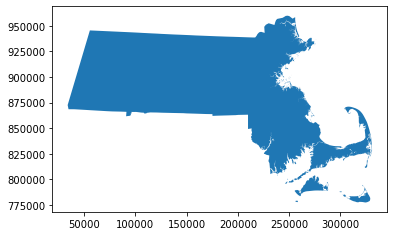

In [67]:
#Use the provided MA outline with detailed coastline OUTLINE25K_POLY.shp to clip the ZCTAs shapefile tl_2010_25_zcta510.shp into the more detailed outline. 
#This will remove the parts of the coastal ZCTAs that extend into the ocean, allowing for a better match with the Boston Region MPO boundary and making your maps more beautiful. 
#This can easily be done using the clip() function from GeoPandas.

#importing a MA outline with detailed coastline
outline25k= gpd.read_file("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\OUTLINE25K_POLY\\OUTLINE25K_POLY.shp")
outline25k.plot()
#Extract the outline of the Boston Region MPO from the MPO boundaries shapefile. (This can be easily done using plain old Pandas boolean indexing.)

#Extract all the ZCTAs whose centroid is within the Boston Region MPO boundary.

Importing ZCTA data

<AxesSubplot:>

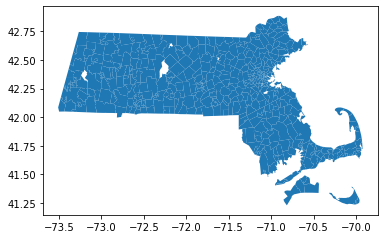

In [11]:
zcta= gpd.read_file("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\tl_2010_25_zcta510\\tl_2010_25_zcta510.shp")
zcta.plot()

In [72]:
#now clip the ZCTAs shapefile into the more detailed outline
#must have the same CRS to be clipped so we need to transform both to PSG:6491, NAD83 (2011) / Massachusetts Mainland 
zcta_proj = zcta.to_crs("EPSG:6491")
outline25k_proj = outline25k.to_crs("EPSG:6491")
#check to ensure the same CRS now
zcta_proj.crs == outline25k_proj.crs

True

In [73]:
#clip ZCTA into more detailed outline
zctas_clipped = gpd.clip(zcta_proj, outline25k_proj)
zctas_clipped

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
0,25,02536,2502536,B5,G6350,S,71696166,9066635,+41.5969756,-070.5678768,N,"MULTIPOLYGON (((275688.314 812598.785, 275674...."
1,25,02556,2502556,B5,G6350,S,10034104,1164445,+41.6394454,-070.6245149,N,"MULTIPOLYGON (((272816.173 818906.998, 272692...."
2,25,02540,2502540,B5,G6350,S,27746696,4550024,+41.5741900,-070.6282848,N,"MULTIPOLYGON (((273126.263 818856.200, 273125...."
3,25,02646,2502646,B5,G6350,S,7798581,801405,+41.6705961,-070.0714493,N,"MULTIPOLYGON (((318348.040 826281.410, 318355...."
4,25,01237,2501237,B5,G6350,S,160121626,1140685,+42.5478177,-073.2680327,N,"POLYGON ((57310.861 917322.668, 57280.413 9173..."
...,...,...,...,...,...,...,...,...,...,...,...,...
533,25,01537,2501537,B5,G6350,S,18085937,295745,+42.1589660,-071.8970514,N,"POLYGON ((167131.394 882124.787, 167132.834 88..."
534,25,01503,2501503,B5,G6350,S,33598202,523984,+42.3849290,-071.6338895,N,"POLYGON ((192620.359 903410.285, 192571.893 90..."
535,25,01452,2501452,B5,G6350,S,106373488,2406515,+42.4895983,-072.0028783,N,"POLYGON ((155270.303 910753.057, 155048.771 91..."
536,25,01571,2501571,B5,G6350,S,53915863,2717076,+42.0537777,-071.9350751,N,"POLYGON ((162378.916 864062.624, 162368.069 86..."


Now we will import a shapefile so we can focus analysis on the Boston Metropolitan Area as defined by the boundary of the Boston Region Metropolitan Planning Organization (MPO).

In [240]:
mpo= gpd.read_file("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\MPO_Boundaries\\MPO_Boundaries.shp")
#first things first check coordinate system
mpo.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [241]:
#change to PSG:6491, NAD83 (2011) / Massachusetts Mainland 
mpo = mpo.to_crs("EPSG:6491")
mpo.crs

<Projected CRS: EPSG:6491>
Name: NAD83(2011) / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [242]:
#extract boston region from MPO, using centroid within 
zcta_boston = zcta[zcta.centroid.within(mpo['geometry'][10])]

<AxesSubplot:>

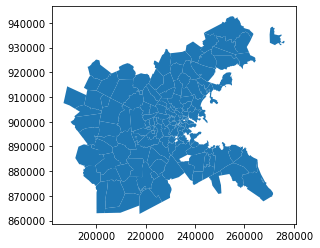

In [224]:
zcta_boston.plot()

Data for Demographic & Social Indicators

After adding transport access indicators, we take into account demographic and social indicators.

In [267]:
#indicator for age and sex, csv format
#the first variable we want from here is S0101_C02_006E which represents the estimated percent of the total population that is aged 20-24, by zip code
#we want to join the matching GEO IDs
census= pd.read_csv("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\ACSST5Y2019.S0101\\ACSST5Y2019.S0101_data_with_overlays.csv",skiprows=[1])
census

,GEO_ID,NAME,S0101_C01_001E,S0101_C01_001M,S0101_C01_002E,S0101_C01_002M,S0101_C01_003E,S0101_C01_003M,S0101_C01_004E,S0101_C01_004M,...,S0101_C06_034E,S0101_C06_034M,S0101_C06_035E,S0101_C06_035M,S0101_C06_036E,S0101_C06_036M,S0101_C06_037E,S0101_C06_037M,S0101_C06_038E,S0101_C06_038M
0,8600000US01001,ZCTA5 01001,17312,735,956,233,863,222,967,274,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
1,8600000US01002,ZCTA5 01002,30014,485,872,143,1043,192,1123,215,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
2,8600000US01003,ZCTA5 01003,11357,477,0,19,0,19,0,19,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
3,8600000US01005,ZCTA5 01005,5128,404,127,72,199,139,408,153,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
4,8600000US01007,ZCTA5 01007,15005,20,879,183,828,186,969,193,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,8600000US02777,ZCTA5 02777,16567,23,565,178,968,213,1004,158,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
533,8600000US02779,ZCTA5 02779,6730,20,263,113,554,234,434,139,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
534,8600000US02780,ZCTA5 02780,50438,654,3022,439,2839,402,3605,486,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
535,8600000US02790,ZCTA5 02790,15793,225,573,231,747,236,730,210,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)


In [249]:
#read in bus stops file
buspoints= gpd.read_file("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\MBTA_Bus_Stops\\MBTA_Bus_Stops.shp")
buspoints.head(8)

,OBJECTID,STOP_ID,STOP_NAME,TOWN,TOWN_ID,geometry
0,1,3077,Gallivan Blvd @ opp Marsh St,BOSTON,35,POINT (237120.669 892643.408)
1,2,841,Lagrange St @ Virgil Rd,BOSTON,35,POINT (227915.195 892644.017)
2,3,446,Norfolk St @ Nelson St,BOSTON,35,POINT (234385.661 892644.944)
3,4,847,Lagrange St opp Virgil St,BOSTON,35,POINT (227912.601 892650.156)
4,5,3079,Adams St @ Minot St,BOSTON,35,POINT (236644.812 892651.990)
5,6,8687,Adams St @ Minot St,BOSTON,35,POINT (236649.767 892672.199)
6,7,808,Centre St opp Bellevue st,BOSTON,35,POINT (228299.467 892674.321)
7,8,33076,Gallivan Blvd @ Hallet St,BOSTON,35,POINT (237367.877 892703.008)


In [250]:
#set crs
buspoints = buspoints.to_crs("EPSG:6491")

In [264]:
#read in T stops file
tpoints= gpd.read_file("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\MBTA_NODE\\MBTA_NODE.shp")
#look at crs
tpoints.crs

<Projected CRS: EPSG:26986>
Name: NAD83 / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

These MBTA nodes are projected in the older standard of EPSG:26986 used by Massachusetts GIS. We will reproject to EPSG:6491, the newer and slightly more accurate standard recommended for mainland Massachusetts.

In [265]:
tpoints = tpoints.to_crs("EPSG:6491")
#check to make sure it reprojected
tpoints.crs

<Projected CRS: EPSG:6491>
Name: NAD83(2011) / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

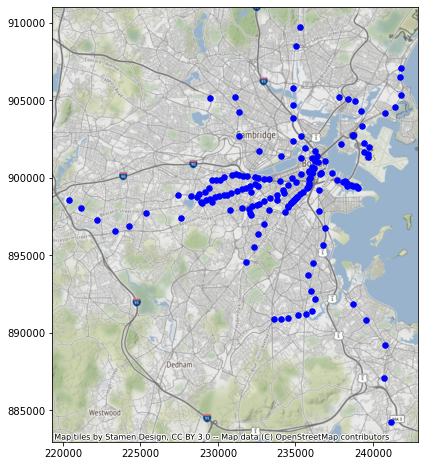

In [148]:
#plotting t points within Boston zip codes
import contextily as cx
fig, ax = plt.subplots(figsize=(10,8))

#need to add title and make map size larger
tpoints.plot(ax=ax, color='blue', markersize=30);

#zcta_boston.plot(ax=ax, facecolor='gray');

cx.add_basemap(ax, crs=tpoints.crs.to_string()) #crs to string outputs coordinates of tpoints dataset

In [182]:
joined_ts

,STATION,LINE,TERMINUS,ROUTE,geometry,index_right,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10
0,Ashmont,RED,Y,A - Ashmont C - Alewife,POINT (236007.538 892693.023),316.0,25,02124,2502124,B5,G6350,S,7777026.0,186127.0,+42.2858047,-071.0705705,N
1,Harvard,RED,N,A - Ashmont B - Braintree C - Alewife,POINT (231387.274 902684.016),367.0,25,02138,2502138,B5,G6350,S,7097709.0,838564.0,+42.3796372,-071.1351523,N
2,Kendall/MIT,RED,N,A - Ashmont B - Braintree C - Alewife,POINT (234087.917 901406.551),451.0,25,02142,2502142,B5,G6350,S,716170.0,577829.0,+42.3614712,-071.0819939,N
3,Capen Street,RED,N,Mattapan Trolley,POINT (234055.438 890869.375),521.0,25,02186,2502186,B5,G6350,S,33697230.0,765195.0,+42.2415889,-071.0826511,N
4,Tufts Medical Center,ORANGE,N,Forest Hills to Oak Grove,POINT (235900.324 899934.313),467.0,25,02116,2502116,B5,G6350,S,1632629.0,265681.0,+42.3505793,-071.0763972,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,East Berkeley Street,SILVER,N,SL4 SL5,POINT (235778.434 899384.292),53.0,25,02118,2502118,B5,G6350,S,2850698.0,15328.0,+42.3378600,-071.0698052,N
162,Herald Street,SILVER,N,SL4 SL5,POINT (235865.742 899637.746),53.0,25,02118,2502118,B5,G6350,S,2850698.0,15328.0,+42.3378600,-071.0698052,N
163,Tuffs Medical Center,SILVER,N,SL4 SL5,POINT (235939.100 899996.710),467.0,25,02116,2502116,B5,G6350,S,1632629.0,265681.0,+42.3505793,-071.0763972,N
164,Black Falcon Ave,SILVER,N,SL2,POINT (238957.352 899405.356),392.0,25,02210,2502210,B5,G6350,S,2399614.0,1404157.0,+42.3477923,-071.0395624,N


In [243]:
#2) Summarize the indicator values of T points for each ZCTA in the study area.
joined_ts = gpd.sjoin(tpoints, zcta_boston, how='left', op='intersects') 
#Group by number of stations per zip code
ts_perzip = joined_ts.groupby('ZCTA5CE10')[['STATION']].nunique().reset_index() #double square brackets for df
#ts_perzip.sort_values(by='nunique',ascending=False)
ts_perzip.rename(columns={'STATION':'station_count'},inplace=True)
#need to join back to zip codes df
zcta_boston = zcta_boston.merge(ts_perzip, how='left', on='ZCTA5CE10')
#in station_count replace NaNs with 0
zcta_boston['station_count'] = zcta_boston['station_count'].fillna(0)
#take a look at new df to be used for visuals
zcta_boston

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,station_count
0,25,01905,2501905,B5,G6350,S,9219345,1195154,+42.4659985,-070.9757922,N,"POLYGON ((243830.175 913871.662, 243877.753 91...",0.0
1,25,01904,2501904,B5,G6350,S,11708211,1303900,+42.4924563,-070.9739297,N,"POLYGON ((245713.029 914796.777, 245700.484 91...",0.0
2,25,01915,2501915,B5,G6350,S,39091336,3958118,+42.5702688,-070.8669962,N,"POLYGON ((250741.171 926889.812, 250787.714 92...",0.0
3,25,02462,2502462,B5,G6350,S,1369318,69749,+42.3287076,-071.2559002,N,"MULTIPOLYGON (((222090.890 897305.465, 222058....",1.0
4,25,01760,2501760,B5,G6350,S,38359306,2599042,+42.2848223,-071.3488109,N,"POLYGON ((208151.539 893024.178, 208131.535 89...",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,25,02071,2502071,B5,G6350,S,2513156,33452,+42.1034247,-071.2735885,N,"MULTIPOLYGON (((217320.943 872620.799, 217310....",0.0
157,25,02343,2502343,B5,G6350,S,18146751,280250,+42.1489129,-071.0037371,N,"POLYGON ((243087.621 878272.261, 243078.760 87...",0.0
158,25,02129,2502129,B5,G6350,S,3492181,1266666,+42.3796570,-071.0614875,N,"POLYGON ((235383.264 902518.035, 235381.204 90...",2.0
159,25,02128,2502128,B5,G6350,S,12561059,2952872,+42.3611289,-071.0069754,N,"POLYGON ((237939.099 904138.351, 237949.737 90...",10.0


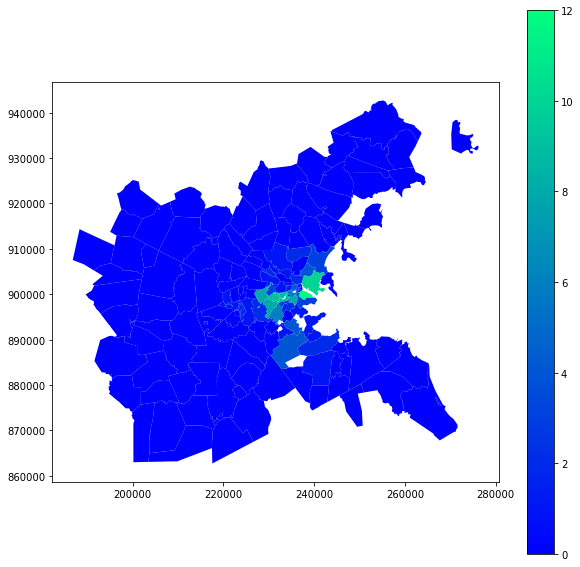

In [244]:
#3)Produce a choropleth map visualizing the indicator values and produce a ZCTA ranking based on the indicator values, reporting the highest and lowest ranking ZCTAs.

#add the contextily basemap, add title

#ranking: number of Ts per zip code
zcta_boston.plot(column='station_count',
           alpha=1,
           #ax=base,
           legend=True,
           cmap='winter',
           figsize=(10, 10))
plt.show()

Below we see the 5 zip codes most saturated with T stations, and 5 of the zip codes that do not contain any.

In [253]:
#3 contd. produce a ZCTA ranking based on the indicators
zcta_sorted = zcta_boston.sort_values(by=['station_count'], ascending=False)
zcta_sorted

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,station_count
120,25,02210,2502210,B5,G6350,S,2399614,1404157,+42.3477923,-071.0395624,N,"POLYGON ((236840.995 900200.325, 236796.115 90...",12.0
159,25,02128,2502128,B5,G6350,S,12561059,2952872,+42.3611289,-071.0069754,N,"POLYGON ((237939.099 904138.351, 237949.737 90...",10.0
84,25,02446,2502446,B5,G6350,S,3333660,11957,+42.3435034,-071.1222479,N,"POLYGON ((230796.803 900058.050, 230823.582 90...",9.0
155,25,02215,2502215,B5,G6350,S,1979040,280050,+42.3475927,-071.1029340,N,"POLYGON ((230893.478 900182.882, 230882.811 90...",9.0
55,25,02115,2502115,B5,G6350,S,1834246,103612,+42.3363418,-071.1041760,N,"POLYGON ((233791.347 900201.106, 233785.591 90...",9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,25,02163,2502163,B5,G6350,S,256727,32165,+42.3661684,-071.1228503,N,"POLYGON ((230919.432 901942.469, 230987.287 90...",0.0
53,25,02121,2502121,B5,G6350,S,4520355,23476,+42.3062667,-071.0858974,N,"POLYGON ((233437.788 896011.798, 233455.909 89...",0.0
51,25,02113,2502113,B5,G6350,S,260829,0,+42.3653348,-071.0552357,N,"POLYGON ((236709.574 901967.559, 236727.610 90...",0.0
50,25,02021,2502021,B5,G6350,S,48682844,2114286,+42.1757371,-071.1253849,N,"POLYGON ((230413.368 886376.020, 230415.894 88...",0.0


In order to develop a suitability indicator based on this data, we next normalize the indicator values into a suitability index ranging from 0 to 1. Locations with the most train stations should be at the highest end of this scale. Below is the new data frame with a column added for normalized values.

In [262]:
#4 Derive feature to raster based on Euclidean proximity to train stops 
#Normalize the indicator values into a suitability or vulnerability index ranging from zero to one.

zcta_boston['stations_norm'] = (zcta_boston['station_count']-zcta_boston['station_count'].min())/(zcta_boston['station_count'].max()-zcta_boston['station_count'].min())
zcta_boston

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,station_count,stations_norm
0,25,01905,2501905,B5,G6350,S,9219345,1195154,+42.4659985,-070.9757922,N,"POLYGON ((243830.175 913871.662, 243877.753 91...",0.0,0.000000
1,25,01904,2501904,B5,G6350,S,11708211,1303900,+42.4924563,-070.9739297,N,"POLYGON ((245713.029 914796.777, 245700.484 91...",0.0,0.000000
2,25,01915,2501915,B5,G6350,S,39091336,3958118,+42.5702688,-070.8669962,N,"POLYGON ((250741.171 926889.812, 250787.714 92...",0.0,0.000000
3,25,02462,2502462,B5,G6350,S,1369318,69749,+42.3287076,-071.2559002,N,"MULTIPOLYGON (((222090.890 897305.465, 222058....",1.0,0.083333
4,25,01760,2501760,B5,G6350,S,38359306,2599042,+42.2848223,-071.3488109,N,"POLYGON ((208151.539 893024.178, 208131.535 89...",0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,25,02071,2502071,B5,G6350,S,2513156,33452,+42.1034247,-071.2735885,N,"MULTIPOLYGON (((217320.943 872620.799, 217310....",0.0,0.000000
157,25,02343,2502343,B5,G6350,S,18146751,280250,+42.1489129,-071.0037371,N,"POLYGON ((243087.621 878272.261, 243078.760 87...",0.0,0.000000
158,25,02129,2502129,B5,G6350,S,3492181,1266666,+42.3796570,-071.0614875,N,"POLYGON ((235383.264 902518.035, 235381.204 90...",2.0,0.166667
159,25,02128,2502128,B5,G6350,S,12561059,2952872,+42.3611289,-071.0069754,N,"POLYGON ((237939.099 904138.351, 237949.737 90...",10.0,0.833333


In [154]:
#read in farmers markets
markets = gpd.read_file("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\FARMERSMARKETS_PT\\FARMERSMARKETS_PT.shp")
#set crs
markets = markets.to_crs("EPSG:6491")
markets.crs

<Projected CRS: EPSG:6491>
Name: NAD83(2011) / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

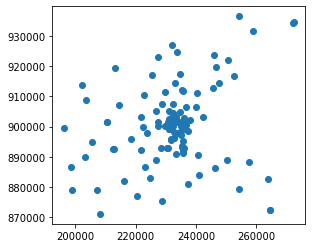

In [158]:
#plotting markets 
markets_clipped = gpd.clip(markets, zcta_boston)
markets_clipped.plot()

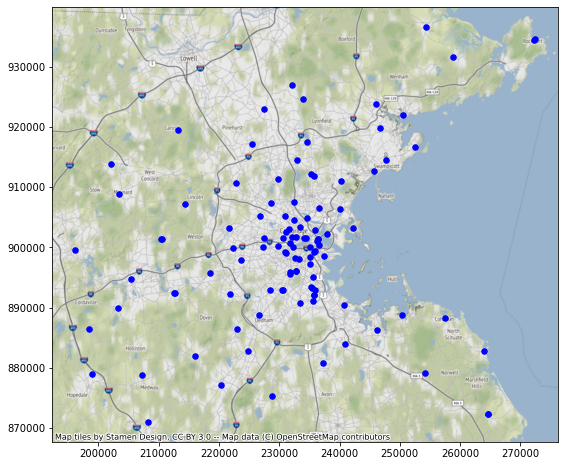

In [159]:
#plotting t points within Boston zip codes
import contextily as cx
fig, ax = plt.subplots(figsize=(10,8))

#need to add title and make map size larger
markets_clipped.plot(ax=ax, color='blue', markersize=30);

#zcta_boston.plot(ax=ax, facecolor='gray');

cx.add_basemap(ax, crs=markets_clipped.crs.to_string()) #crs to string outputs coordinates of tpoints dataset

In [160]:
markets_raster = features.rasterize(markets['geometry'], fill=1, default_value=0)

ValueError: Either an out_shape or image must be provided

#For each chosen indicator:
#If applicable, visualize any spatial data the indicator is based on. (For example, the locations of certain POIs.)

//Summarize the indicator values (like population density) for each ZCTA in the study area.//


Produce a choropleth map visualizing the indicator values and produce a ZCTA ranking based on the indicator values, reporting the highest and lowest ranking ZCTAs.



#Convert the indicator values into a suitability or vulnerability index or score. This can be done in two ways:


#Reclassify the indicator values based on classes of your choice into a five-point (or ten-point) score.

Summarize the single indicator based scores or indices into an overall weighted or unweighted score or index. You should justify any chosen weights or the decision to forego weighting the indicators (assigning each indicator an equal weight). You are welcome to produce both a weighted and an unweighted overall index or score.


Visualize the overall suitability or vulnerability index or score on a choropleth map and produce a ZCTA ranking based on the score or index, reporting the highest and lowest ranking ZCTAs.

Unweighted index results:

Weighted index results: